In [1]:
# # !conda activate ai_workshop
# -q flag stands for "quiet"
!git clone https://github.com/PolymathicAI/the_well -q
# we checkout this commit since the most recent ones all have one bug for data normalization
!cd the_well;git checkout e8a936f2e78b48dc62fc175df2e66d365e6bc6a9; pip install -q .


from the_well.data import WellDataset
from the_well.utils.download import well_download
base_path = './the_well/'

fatal: destination path 'the_well' already exists and is not an empty directory.
HEAD is now at e8a936f Download dataset statistics files along data (#22)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Steps doing AI4Science

The state-of-the-art AI techniques are usually not initially designed for scientific problem. To adopt them for scientific usage, we need to do the following steps -- 

1. Fomulate the problem into viable form that AI models can understand. This means data curation and formating.
2. Find appropriate architectures that fit the problem.
3. Find appropriate loss objective to train the model -- with both data and physics.

In [2]:
# download and setup the dataset
well_download(base_path=base_path, dataset="turbulent_radiative_layer_2D", split='train')
well_download(base_path=base_path, dataset="turbulent_radiative_layer_2D", split='test')

In [3]:

dataset_path = './the_well/datasets'
train_dataset = WellDataset(
    well_base_path=dataset_path,
    well_dataset_name="turbulent_radiative_layer_2D",
    well_split_name="train",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=True,
    # normalization_type=normalization.ZScoreNormalization,
)

test_dataset = WellDataset(
    well_base_path=dataset_path,
    well_dataset_name="turbulent_radiative_layer_2D",
    well_split_name="test",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=True,
    # normalization_type=normalization.ZScoreNormalization,
)


## One line description of the data

Everywhere in astrophysical systems hot gas moves relative to cold gas, which leads to mixing, and mixing populates intermediate temperature gas that is highly reactive—in this case it is rapidly cooling.

## Longer description of the data

In this simulation, there is cold, dense gas on the bottom and hot dilute gas on the top. They are moving relative to each other at highly subsonic velocities. This set up is unstable to the Kelvin Helmholtz instability, which is seeded with small scale noise that is varied between the simulations. The hot gas and cold gas are both in thermal equilibrium in the sense that the heating and cooling are exactly balanced. However, once mixing occurs as a result of the turbulence induced by the Kelvin Helmholtz instability the intermediate temperatures become populated. This intermediate temperature gas is not in thermal equilibrium and cooling beats heating. This leads to a net mass flux from the hot phase to the cold phase. This process occurs in the interstellar medium, and in the Circum-Galactic medium when cold clouds move through the ambient, hot medium. By understanding how the total cooling and mass transfer scale with the cooling rate we are able to constrain how this process controls the overall phase structure, energetics and dynamics of the gas in and around galaxies.


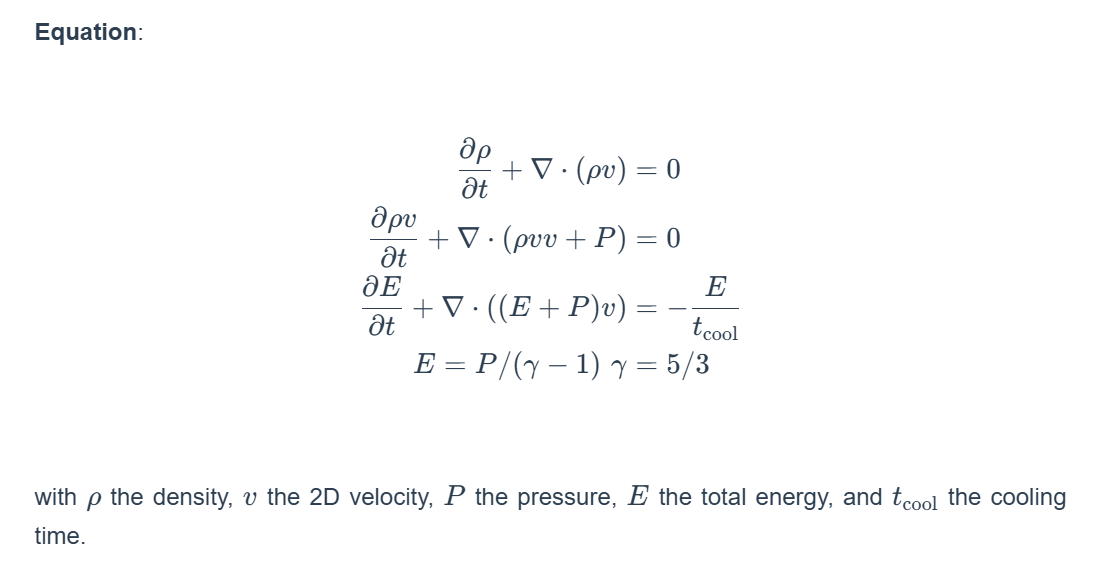


In [4]:
# setup dataloader from the dataset
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)



## Step 1 -- data curation

In this case we discretize the time dependent problem to using past snapshots of the physical system to predict the next snapshots. Each snapshot is $\delta T$ away from the before or after ones and is seen as regular grid to the model.

By arranging the snapshots onto the regular grid, we are able to use a lot of the techniques and architectures that the Computer Vision community has well studied. In this case we use Vision Transformer.

In [5]:
import einops
for batch in train_loader:
    break
for key in batch:
    print(f'Item : {key}, shape {batch[key].shape}')

def batch_parser(batch, device):
    inputs = batch['input_fields']
    outputs = batch['output_fields']

    inputs = einops.rearrange(inputs, 'N T H W C -> N (T C) H W')
    outputs = einops.rearrange(outputs, 'N T H W C -> N (T C) H W')
    return inputs.to(device), outputs.to(device)

for batch in train_loader:
    inputs, outputs = batch_parser(batch, 'cpu')
    break

Item : input_fields, shape torch.Size([16, 4, 128, 384, 4])
Item : output_fields, shape torch.Size([16, 1, 128, 384, 4])
Item : constant_scalars, shape torch.Size([16, 1])
Item : boundary_conditions, shape torch.Size([16, 2, 2])
Item : space_grid, shape torch.Size([16, 128, 384, 2])
Item : input_time_grid, shape torch.Size([16, 4])
Item : output_time_grid, shape torch.Size([16, 1])


![dataset](https://users.flatironinstitute.org/~polymathic/data/the_well/datasets/turbulent_radiative_layer_2D/gif/density_normalized.gif)

In [6]:
import torch
from torch import nn
import numpy as np

import math

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm as tqdm

device = 'cuda:0'

## Step 2 -- Architecture Selection

We use Vision Transformer, which has been a state-of-the-art architecture for ImageNet classification since 2021. It is characterized as a parameter rich and flexible architecture that is highly capable of learning complex representations. We would also show the result using Fourier Neural Operator later, an architecture that was invented for the usage of scientific machine learning. Different architectures have different characteristics that fit different problems.

# We first start with attention mechanism.

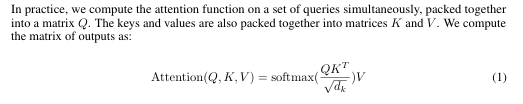

To break it down with basic linear algebra operation, we first define the shape of `q, k, v` as `1F, KF, KV`, where `1` means we only want to query one time, `F, V` are the feature dimensions, and `K` is the number of vectors from whom we will get the average weights.


We first compute the cosine similarity between the one query vectors and the key vectors as $QK^\intercal$, which results in a matrix $W$ of shape `1K`, whose entries are all the inner product between the query vectors and the individual key vectors.

Once we get the similarity matrix $W$, we need to normalize each row (in this case just 1 row) so that they are positive, and add up to 1 and can be used to compute the weighted average. We do this by using the softmax functions $softmax(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$.

The scale $\sqrt{K}$ comes from the (very weak) normality assumptions on the initialization of the parameters. We would not dig into that. But this theoretically ensures that the entries of the similarity matrix $W$ follows some distribution that is independent of the number of keys $K$ at initialization.

Once we get the softmaxed score $W_{soft}$ we can go ahead and make weighted average of all the value vectors to get the query result. Mathematically it is simply done by $W_{soft}V$.

## Extension to general purpose multi-head attention

We have shown how to query one vector, but the batched ones are no different from just querying single vector.

Now we have `1F,KF,KV\->1F`.

Querying multiple queries on the same set of key/value vectors would be `QF,KF,KV->QV`.

Adding a batch dimension, we get `BQF,BKF,BQV->BQV`, and is doen by broadcasting the matrix operations along the batch dimension.

Further adding the multi-head-ness, which is essentially running the same attention in parallel along the head dimension `H`, we get `BQHF,BKHF,BQHV->BQHV`

## NOTE

Attention is merely a weighted average of a set of vectors, but it does not introduce channel-wise mixing -- since all the channels of the values vectors are averaged using the same score! That is why we need to add a 1 hidden layer neural network after the attention, since the neural network applied to single vectors do its job of mixing the channels.

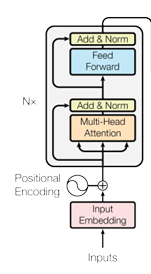

In [7]:
# def dot_product_attention(q, k, v):
#     # q, k, v: query, key and value, all with shape (batch_size, sequence_length, hidden feature dimension)
#     # shortened to (b, s, f)
#     # 'bqf,bkf->bqk' means we take the inner product by the feature dimension, pair-wise
#     attention_matrix = torch.einsum('bqf,bkf->bqk', q, k)


#     # normalize by square root of number of key/value
#     attention_matrix = attention_matrix / math.sqrt(k.shape[1])
#     # get attention weights on keys for each query
#     attention_weights = nn.functional.softmax(attention_matrix, dim=-1)
#     # take the weighted average of the value
#     return torch.einsum('bqk,bkf->bqf', attention_weights, v)

def dot_product_attention(q, k, v):

    attention_matrix = torch.einsum('...qf,...kf->...qk', q, k)
    attention_matrix = attention_matrix / math.sqrt(k.shape[-2])
    attention_weights = nn.functional.softmax(attention_matrix, dim=-1)
    # we can use elipsis to make it more general
    return torch.einsum('...qk,...kf->...qf', attention_weights, v)
def multihead_dot_product_attention(q, k, v, num_heads):
    # multihead dot product attention means the last feature dimension is splitted to multiple trunks (or heads)
    # somehow einops requires space between dimension names
    q = einops.rearrange(q, '... s (h f) -> ... h s f', h=num_heads)
    k = einops.rearrange(k, '... s (h f) -> ... h s f', h=num_heads)
    v = einops.rearrange(v, '... s (h f) -> ... h s f', h=num_heads)

    q = dot_product_attention(q, k, v)

    q = einops.rearrange(q, '... h s f -> ... s (h f)', h=num_heads)

    return q

In practice, we often only split the key and value vectors at the very end -- we get the key/value pair from one feature vector by using two sets of linear layer, instead of explicitly keeping 2 seperate networks running for the key/value vectors.

## Self attention

We set `Q, K, V` to be the same. So each query result would be a weighted average of the same set of vectors it comes from. In this case the shape is unchanged.

## Cross attention

We set `K, V` to be different from `Q`. So the query results are independent from other queries. This is useful to output a continuous function.

# Positional Embedding

The linear nature of the attention mechanism brings in permutation invariance. That is, permuting the key/value pairs in the sqeuence would not introduce any difference in the results, since the pre-softmax logit would not be different before and after the permutation, for certain pair of key/value. To address this issue, we therefore need positional embedding to tell the model where each token, or feature vector, is from.

For example, if we divide the images into patches and flatten the patches for key/value vectors, then one single query on the set of flattend patches would give the same result no matter how the image has been permutated

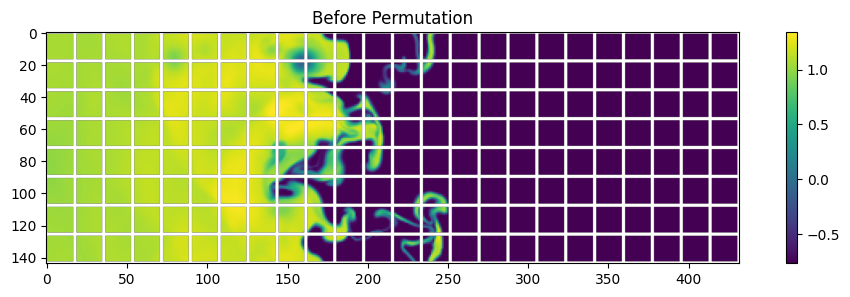

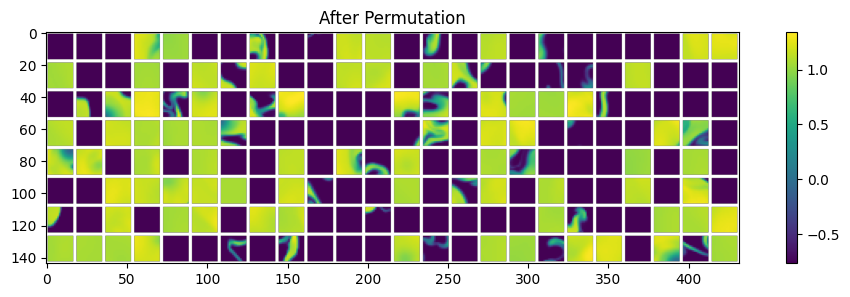

In [8]:
image = inputs[0,0]

patches = einops.rearrange(image, '(h p1) (w p2) -> (h w) p1 p2', p1=16, p2=16)
patches = np.pad(patches, ((0,0),(1,1),(1,1)), mode='constant', constant_values=np.nan)

before_permute = einops.rearrange(patches.copy(), '(h w) p1 p2 -> (h p1) (w p2)', h = 128 // 16, w = 384 // 16)
permute_index = np.random.permutation(patches.shape[0])
patches = patches[permute_index]
patches = einops.rearrange(patches, '(h w) p1 p2 -> (h p1) (w p2)', h = 128 // 16, w = 384 // 16)
plt.figure(figsize=(12,3))
plt.imshow(before_permute, cmap='viridis')
plt.colorbar()
plt.title('Before Permutation')
plt.show()
plt.close()


plt.figure(figsize=(12,3))
plt.imshow(patches, cmap='viridis')
plt.colorbar()
plt.title('After Permutation')
plt.show()
plt.close()


## Positional Embedding

Mathematically, the additive positional embedding used widely can be expressed as

$\text{embed}(x) = [\sin(x / 2^j)]$, where $j$s are usually evenly scaled in the log scale.

In [9]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_scale, min_scale, in_shape, out_features):
        super().__init__()


        if isinstance(in_shape, int):
            in_shape = (in_shape, )
        #2HW
        indices = np.indices(in_shape)
        indices = torch.tensor(indices)
        # this is the actual number of frequency
        num_features = out_features // 2 // len(in_shape)

        div_term_left = -math.log2(max_scale)
        div_term_right = -math.log2(min_scale)

        div_term = 2 ** torch.linspace(div_term_left, div_term_right, num_features)

        pos_embd = torch.einsum('d...,f->df...', indices, div_term).flatten(0,1)
        pos_embd = torch.concatenate([torch.sin(pos_embd), torch.cos(pos_embd)], dim=0)

        self.pos_embd = nn.Parameter(pos_embd)


    def forward(self, x):
        # expand the dimension of the positional embedding to match the batch dimension
        pos_embd = self.pos_embd[(None,)*(x.ndim - self.pos_embd.ndim)]
        return x + pos_embd

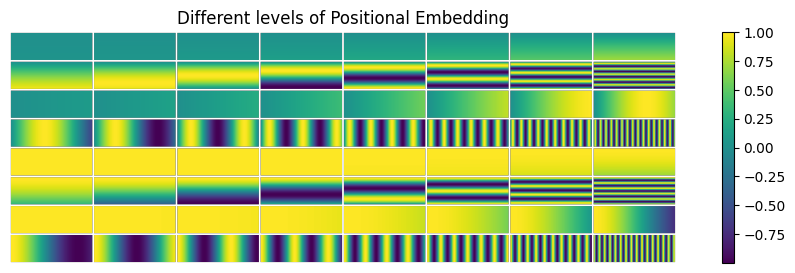

In [10]:
embd = PositionalEmbedding(1e3, 1, (32, 96), 64)

pos_embd = embd.pos_embd.detach()

pos_embd = np.pad(pos_embd, ((0,0),(1,1),(1,1)), mode='constant', constant_values=np.nan)

pos_embd = einops.rearrange(pos_embd, '(h w) p1 p2 -> (h p1) (w p2)', h = 8, w = 8)

plt.figure(figsize=(12,3))
plt.imshow(pos_embd, cmap='viridis')
plt.axis('off')
plt.colorbar()
plt.title('Different levels of Positional Embedding')
plt.show()
plt.close()

In [11]:



class MultiHeadDotProductAttention(nn.Module):
    def __init__(self, input_dims, qkv_dim, num_heads, out_dim):
        super().__init__()

        if isinstance(input_dims, int):
            input_dims = (input_dims, input_dims, input_dims)

        q_dim, k_dim, v_dim = input_dims

        self.q_linear = nn.Linear(in_features = q_dim, out_features=qkv_dim)
        self.k_linear = nn.Linear(in_features = k_dim, out_features=qkv_dim)
        self.v_linear = nn.Linear(in_features = v_dim, out_features=out_dim)

        self.num_heads = num_heads

    def forward(self, q, k, v):
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)

        return multihead_dot_product_attention(q, k, v, num_heads = self.num_heads)


class FeedForward(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.linear_0 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.linear_1 = nn.Linear(in_features=hidden_features, out_features=out_features)
        # reuse the input buffer to save up time
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.linear_0(x)
        x = self.relu(x)
        x = self.linear_1(x)

        return x


class LayerNorm(nn.Module):
    def __init__(self,shape, eps=1e-5):
        super().__init__()

        if isinstance(shape, int):
            shape =    (shape,)

        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

        self.eps = eps
        self.shape = shape
    def forward(self, x):
        std = x.std(dim=tuple(range(x.ndim - len(self.shape), x.ndim)), keepdim=True)
        mean = x.mean(dim=tuple(range(x.ndim - len(self.shape), x.ndim)), keepdim=True)

        x = (x - mean) / (std + self.eps)
        return self.gamma * x + self.beta


class TransformerEncoder(nn.Module):
    def __init__(self, qkv_dim, in_features, ffl_hidden_dim, num_heads):
        super().__init__()

        self.attention = MultiHeadDotProductAttention(input_dims=in_features, qkv_dim=qkv_dim, num_heads=num_heads, out_dim=qkv_dim)
        self.ffl = FeedForward(in_features = qkv_dim, hidden_features = ffl_hidden_dim, out_features=qkv_dim)

        self.norm0 = LayerNorm(qkv_dim)
        self.norm1 = LayerNorm(qkv_dim)

    def forward(self, x):
        # this is called pre-norm, where normalization occurs before the sub layer. pre norm is used by modern transformers.
        norm_x = self.norm0(x)
        att = self.attention(norm_x, norm_x, norm_x)
        # attention and residual connection
        x = att + x

        norm_x = self.norm1(x)
        # feedforward for channel mixing, and residual connection again.
        ffl_out = self.ffl(norm_x)

        return ffl_out + x








class VisionTransformer(nn.Module):
    def __init__(self, in_features, out_dim, qkv_dim, num_heads, num_layers, patch_size, image_size):
        super().__init__()

        H, W = image_size


        self.patch_conv = nn.Conv2d(
            in_channels=in_features,
            out_channels=qkv_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding='valid'
        )

        self.pos_embd = PositionalEmbedding(
            max_scale=1e3,
            min_scale=1,
            in_shape=(H // patch_size, W // patch_size),
            out_features=qkv_dim
        )

        self.blocks = nn.ModuleList(
            [TransformerEncoder(qkv_dim=qkv_dim, in_features=qkv_dim, ffl_hidden_dim=2*qkv_dim, num_heads=num_heads) for _ in range(num_layers)]
        )

        self.unpatch_conv = nn.ConvTranspose2d(
            in_channels = qkv_dim,
            out_channels = out_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        self.norm = LayerNorm(qkv_dim)

    def forward(self, x, recon=True):
        x = self.patch_conv(x)
        x = self.pos_embd(x)




        Hp, Wp = x.shape[2:]

        x = x.flatten(2,3)

        x = torch.movedim(x, -1, 1)



        for block in self.blocks:
            x = block(x)


        x = self.norm(x)

        if recon:
            # whether the transformer is used as a feature extractor
            x = x.unflatten(1, (Hp, Wp))
            x = torch.movedim(x, -1, 1)

            return self.unpatch_conv(x)
        else:
            return x




def VRMSE(predictions, targets, mean=False):
    # VRMSE: sqrt(MSE / VAR)

    targets = targets.flatten(2)
    predictions = predictions.flatten(2)

    var = targets.var(-1) + 1e-5

    diff_sq = ((targets - predictions) ** 2).mean(-1)

    err = torch.sqrt(diff_sq / var)

    if mean:
        err = err.mean()

    return err


Once you are familiar with torch, you can directly use the `torch.nn.TransformerEncoder`, and `torch.nn.TransformerEncoderLayer`, which do the same thing but with much much more functionalities.

## Step 3 -- Loss Objective

In this case we use Mean Square Loss in a purely data driven way since The Well datasets are very data rich. Shyam has already shown how to use physics informed losses on problems that are well formulated but data sparse.

In [12]:



for batch in train_loader:
    inputs, outputs = batch_parser(batch, device)
    break
net = VisionTransformer(
    in_features=inputs.shape[1],
    out_dim=outputs.shape[1],
    qkv_dim=256,
    num_heads=4,
    num_layers=4,
    patch_size=8,
    image_size = inputs.shape[2:]
).to(device)
# from neuralop.models import FNO
# net = FNO(n_modes=(16, 16), hidden_channels=64, in_channels=inputs.shape[1], out_channels=outputs.shape[1]).to('cuda')

criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(params = net.parameters(), lr=1e-3, weight_decay=1e-3)

# for n, p in net.named_parameters():
#     print(n, 'device', p.device, 'requires_grad', p.requires_grad)

Epoch 0 / 10, step 0 / 437, train loss : 1.2220, train error: 3.0735
Epoch 0 / 10, step 43 / 437, train loss : 0.3008, train error: 1.0083
Epoch 0 / 10, step 86 / 437, train loss : 0.2466, train error: 0.8423
Epoch 0 / 10, step 129 / 437, train loss : 0.2185, train error: 0.7854
Epoch 0 / 10, step 172 / 437, train loss : 0.2010, train error: 0.7448
Epoch 0 / 10, step 215 / 437, train loss : 0.1936, train error: 0.7252
Epoch 0 / 10, step 258 / 437, train loss : 0.1848, train error: 0.7036
Epoch 0 / 10, step 301 / 437, train loss : 0.1824, train error: 0.6848
Epoch 0 / 10, step 344 / 437, train loss : 0.1785, train error: 0.6721
Epoch 0 / 10, step 387 / 437, train loss : 0.1746, train error: 0.6611
Epoch 0 / 10, step 430 / 437, train loss : 0.1718, train error: 0.6610
Epoch 0 / 10 test error: 0.5664


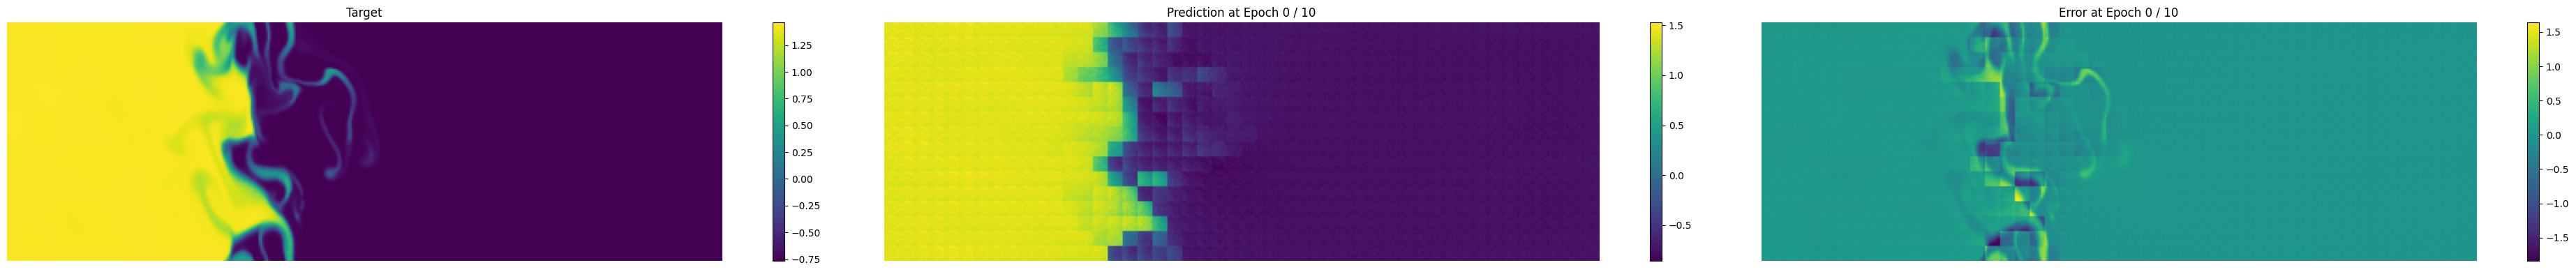

Epoch 1 / 10, step 0 / 437, train loss : 0.1468, train error: 0.5517
Epoch 1 / 10, step 43 / 437, train loss : 0.1360, train error: 0.5396
Epoch 1 / 10, step 86 / 437, train loss : 0.1444, train error: 0.5796
Epoch 1 / 10, step 129 / 437, train loss : 0.1457, train error: 0.5791
Epoch 1 / 10, step 172 / 437, train loss : 0.1439, train error: 0.5718
Epoch 1 / 10, step 215 / 437, train loss : 0.1436, train error: 0.5812
Epoch 1 / 10, step 258 / 437, train loss : 0.1463, train error: 0.5800
Epoch 1 / 10, step 301 / 437, train loss : 0.1463, train error: 0.5788
Epoch 1 / 10, step 344 / 437, train loss : 0.1438, train error: 0.5710
Epoch 1 / 10, step 387 / 437, train loss : 0.1410, train error: 0.5674
Epoch 1 / 10, step 430 / 437, train loss : 0.1389, train error: 0.5679
Epoch 1 / 10 test error: 0.4726


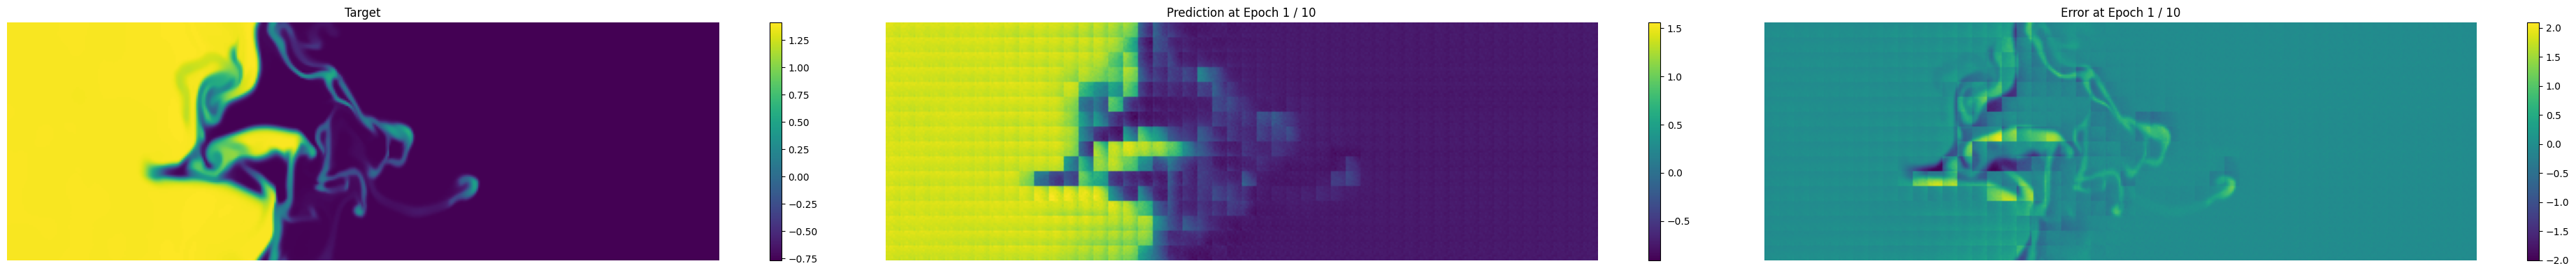

Epoch 2 / 10, step 0 / 437, train loss : 0.0968, train error: 0.4649
Epoch 2 / 10, step 43 / 437, train loss : 0.1124, train error: 0.4967


KeyboardInterrupt: 

In [13]:
num_epoch = 10
counter = 0

for e in range(num_epoch):


    net = net.train()

    train_loss_cum = []
    train_err_cum = []

    for step, batch in enumerate(train_loader):
        inputs, outputs = batch_parser(batch, device)
        optimizer.zero_grad()

        predictions = net(inputs)


        loss = criterion(predictions, outputs)
        train_loss_cum.append(loss.detach().cpu())

        vrmse = VRMSE(predictions, outputs, mean=True)

        train_err_cum.append(vrmse.detach().cpu())

        loss.backward()
        optimizer.step()

        current_train_loss = torch.tensor(train_loss_cum).mean().item()
        current_train_err = torch.tensor(train_err_cum).mean().item()
        counter += 1
        if step % (len(train_loader) // 10) == 0:
        # if step % 100 == 0:
            inputs = inputs.cpu()[0]
            predictions = predictions.detach().cpu()[0]

            print(f'Epoch {e} / {num_epoch}, step {step} / {len(train_loader)}, train loss : {current_train_loss:.4f}, train error: {current_train_err:.4f}')




    train_loss_cum = torch.tensor(train_loss_cum).mean().item()

    test_err_cum = []

    with torch.no_grad():
        net = net.eval()

        for batch in test_loader:
            inputs, outputs = batch_parser(batch, device)
            inputs = inputs.to(device)
            predictions = net(inputs)
            vrmse = VRMSE(predictions, outputs, mean=True)
            test_err_cum.append(vrmse.detach().cpu())
    test_err_cum = torch.tensor(test_err_cum).mean().item()
    print('=============================================================================================')
    print(f'Epoch {e} / {num_epoch} test error: {test_err_cum:.4f}')

    outputs = outputs.detach().cpu()[0]
    predictions = predictions.detach().cpu()[0]

    plt.figure(figsize=(40, 4))

    plt.subplot(1,3,1)
    plt.imshow(outputs[0])
    plt.axis('off')
    plt.colorbar()
    plt.title('Target')
    plt.tight_layout()

    plt.subplot(1,3,2)
    plt.imshow(predictions[0])
    plt.title(f'Prediction at Epoch {e} / {num_epoch}')
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()

    plt.subplot(1,3,3)
    plt.imshow(outputs[0] - predictions[0])
    plt.title(f'Error at Epoch {e} / {num_epoch}')
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()

    plt.show()
    plt.close()

    print('=============================================================================================')



## Transformer allows learning continuous representation of a function

Other than just unflattening, we can also use the transformer cross attention decoder to make the output continuous.

The cross attention transformer decoder only makes the query input to be different from the key/value inputs.

In [14]:
class FourierEmbed(nn.Module):
    def __init__(self, out_features, max_scale=1e3, min_scale=1):
        super().__init__()
        self.min_scale=min_scale
        self.max_scale=max_scale

        self.out_features=out_features


    def forward(self, x):

        x_dim = x.shape[-1]

        num_frequency = self.out_features // x_dim // 2

        div_term = torch.linspace(math.log2(self.min_scale), math.log2(self.max_scale), num_frequency).to(x.device)

        div_term = 2. ** (-div_term)

        x = torch.einsum(
            '...d,f->...df',
            x,
            div_term
        )

        x = torch.concatenate([torch.sin(x), torch.cos(x)], axis=-1)
        x = x.flatten(-2,-1)


        return x




In [15]:

class CrossAttentionDecoder(nn.Module):
    def __init__(self, qkv_dim, in_features, ffl_hidden_dim, num_heads):
        super().__init__()

        self.attention = MultiHeadDotProductAttention(input_dims=in_features, qkv_dim=qkv_dim, num_heads=num_heads, out_dim=qkv_dim)
        self.ffl = FeedForward(in_features = qkv_dim, hidden_features = ffl_hidden_dim, out_features=qkv_dim)

        self.norm0 = LayerNorm(qkv_dim)
        self.norm1 = LayerNorm(qkv_dim)
        self.norm2 = LayerNorm(qkv_dim)

    def forward(self, q, k):
        # this is called pre-norm, where normalization occurs before the sub layer. pre norm is used by modern transformers.
        norm_q = self.norm0(q)
        norm_k = self.norm1(k)

        att = self.attention(norm_q, norm_k, norm_k)
        # attention and residual connection
        x = att + q

        norm_x = self.norm2(x)
        # feedforward for channel mixing, and residual connection again.
        ffl_out = self.ffl(norm_x)

        return ffl_out + x


class ContinuousTransformer(nn.Module):
    def __init__(self, in_features, out_dim, qkv_dim, num_heads, num_layers, patch_size, image_size, num_decoder_layer):
        super().__init__()

        self.backbone = VisionTransformer(in_features, out_dim, qkv_dim, num_heads, num_layers, patch_size, image_size)
        self.fourier_embd = FourierEmbed(out_features=qkv_dim)

        self.decoder_blocks = nn.ModuleList(
            [CrossAttentionDecoder(qkv_dim, qkv_dim, ffl_hidden_dim=2*qkv_dim, num_heads=num_heads) for _ in range(num_decoder_layer)]
        )

        self.out_proj = nn.Linear(in_features=qkv_dim, out_features = out_dim)

    def forward(self, u, x):
        #u: image for the previous steps
        #x: query location where we want to know for the next step

        latent_features = self.backbone(u, recon=False)

        query = self.fourier_embd(x)

        for block in self.decoder_blocks:
            query = block(query, latent_features)

        return self.out_proj(query)




In [16]:
def continuous_batch_parser(batch, device, num_subsample):

    inputs, outputs = batch_parser(batch,'cpu')
    N, C, H, W = outputs.shape
    #S2, .T means transpose
    output_grid = torch.tensor(np.indices(outputs.shape[-2:])).flatten(1,-1).T

    total_size = H * W

    # NS2
    sampled_coordinate = np.random.choice(total_size, (N, num_subsample))

    outputs = outputs.flatten(2,)
    # NSC
    outputs = torch.moveaxis(outputs, source=1,destination=-1)

    outputs = outputs[np.arange(N)[...,None], sampled_coordinate]
    coordinates = output_grid[sampled_coordinate]

    return inputs.to(device), coordinates.to(device), outputs.to(device)


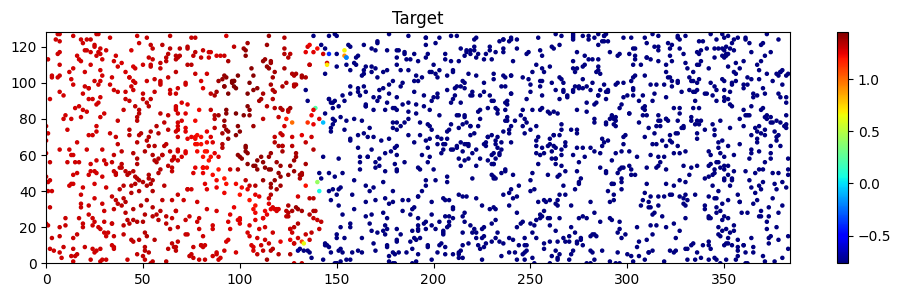

In [17]:
for batch in train_loader:
    break

inputs, coordinates, outputs = continuous_batch_parser(batch, device, 2048)


plt.figure(figsize=(12,3))
# imshow and scatter coordinate system are different
plt.scatter(coordinates[0,...,1].cpu(), coordinates[0,...,0].cpu(), c=outputs[0,...,0].cpu(), s=5, cmap='jet')
plt.colorbar()
plt.title('Target')
plt.xlim(0, 384)
plt.ylim(0, 128)
plt.show()
plt.close()

In [18]:


cnet = ContinuousTransformer(
    in_features=inputs.shape[1],
    out_dim=outputs.shape[-1],
    qkv_dim=256,
    num_heads=4,
    num_layers=4,
    patch_size=8,
    image_size = inputs.shape[2:],
    num_decoder_layer=2
).to(device)

# to save the training for a bit we reuse the previously trained VIT since the backbone is a VIT
# the good thing about transformer is that it is very versatile and can adapt to new tasks faster if pre-trained.
cnet.backbone = net

criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(params = cnet.parameters(), lr=1e-3, weight_decay=1e-3)


In [19]:
def flattened_VRMSE(predictions, targets, mean):
    predictions = torch.swapaxes(predictions, -2,-1)
    targets = torch.swapaxes(targets, -2,-1)

    return VRMSE(predictions, targets, mean)

Epoch 0 / 10, step 0 / 437, train loss : 0.2074, train error: 0.5960
Epoch 0 / 10, step 109 / 437, train loss : 0.2076, train error: 0.6562
Epoch 0 / 10, step 218 / 437, train loss : 0.2014, train error: 0.6740
Epoch 0 / 10, step 327 / 437, train loss : 0.2010, train error: 0.6763
Epoch 0 / 10, step 436 / 437, train loss : 0.1971, train error: 0.6627


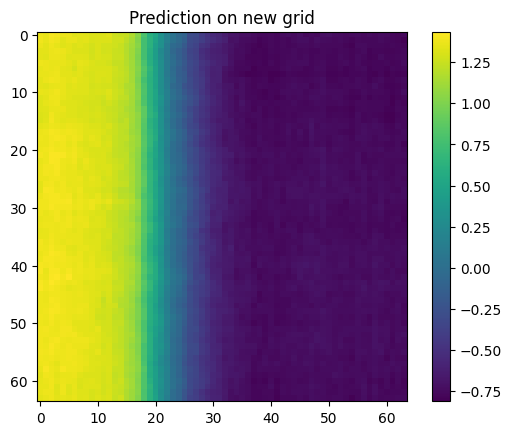

Epoch 1 / 10, step 0 / 437, train loss : 0.1183, train error: 0.5795
Epoch 1 / 10, step 109 / 437, train loss : 0.1930, train error: 0.6244
Epoch 1 / 10, step 218 / 437, train loss : 0.1945, train error: 0.6380
Epoch 1 / 10, step 327 / 437, train loss : 0.1918, train error: 0.6382
Epoch 1 / 10, step 436 / 437, train loss : 0.1925, train error: 0.6388


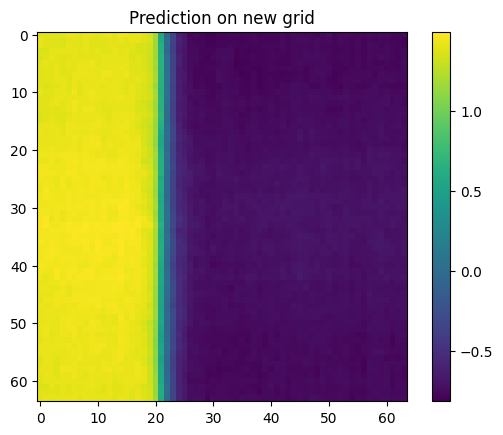

Epoch 2 / 10, step 0 / 437, train loss : 0.1447, train error: 0.5711
Epoch 2 / 10, step 109 / 437, train loss : 0.1948, train error: 0.6324
Epoch 2 / 10, step 218 / 437, train loss : 0.1930, train error: 0.6371
Epoch 2 / 10, step 327 / 437, train loss : 0.1927, train error: 0.6384
Epoch 2 / 10, step 436 / 437, train loss : 0.1911, train error: 0.6372


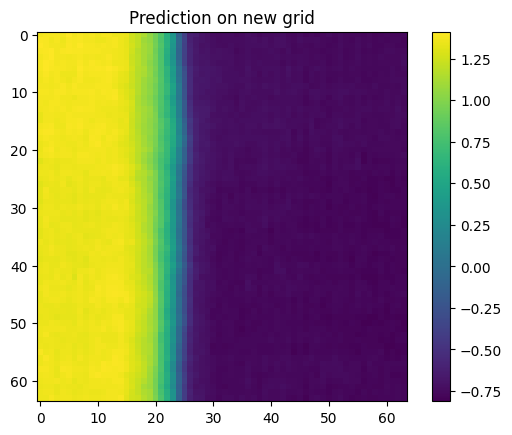

Epoch 3 / 10, step 0 / 437, train loss : 0.1421, train error: 0.6743
Epoch 3 / 10, step 109 / 437, train loss : 0.1926, train error: 0.6205
Epoch 3 / 10, step 218 / 437, train loss : 0.1850, train error: 0.6135
Epoch 3 / 10, step 327 / 437, train loss : 0.1885, train error: 0.6316


In [ ]:
num_epoch = 10
counter = 0

sampled_prediction = []

for e in range(num_epoch):


    cnet = cnet.train()

    train_loss_cum = []
    train_err_cum = []

    for step, batch in enumerate(train_loader):
        inputs, coordinates, outputs = continuous_batch_parser(batch, device, 1024)
        optimizer.zero_grad()

        predictions = cnet(inputs, coordinates)


        loss = criterion(predictions, outputs)
        train_loss_cum.append(loss.detach().cpu())

        vrmse = flattened_VRMSE(predictions, outputs, mean=True)

        train_err_cum.append(vrmse.detach().cpu())

        loss.backward()
        optimizer.step()

        current_train_loss = torch.tensor(train_loss_cum).mean().item()
        current_train_err = torch.tensor(train_err_cum).mean().item()
        counter += 1
        if step % (len(train_loader) // 4) == 0:

            print(f'Epoch {e} / {num_epoch}, step {step} / {len(train_loader)}, train loss : {current_train_loss:.4f}, train error: {current_train_err:.4f}')

    new_grid = torch.meshgrid(
        torch.linspace(0, 127, 64),
        torch.linspace(0, 383, 64)
    )

    new_grid = torch.stack(new_grid, dim=-1).to(device)
    new_grid = new_grid.flatten(0,1)[None,]
    pred_on_new_grid = cnet(inputs[0:1], new_grid)
    sampled_prediction.append(pred_on_new_grid.clone().detach())
    pred_on_new_grid = pred_on_new_grid.unflatten(1, (64, 64)).detach().cpu()[0]


    plt.figure()
    plt.imshow(pred_on_new_grid[...,0], cmap='viridis')
    plt.colorbar()
    plt.title('Prediction on new grid')
    plt.show()
    plt.close()




    train_loss_cum = torch.tensor(train_loss_cum).mean().item()

With continuous transformer implemented, we can evaluate the model in arbitrary locations that are not limited to the grid.